#  **ICT303 - Assignment 2**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>** 

**Email: <enter here your email address>** 

In this assignment, you will build a deep learning model for identifying $120$ different breeds of dogs. Similar to the previous assignment, you will use real images from the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

In this assignment, your are required to use a ResNet network. You can use ResNet implementation provided in PyTorch. Note however  that there are many versions of ResNet (they differ in terms of number of layers). Your task is to find the best configuration that gives the best performance. 

The rule is similar to the previous assignment:

1. Develop a better model to reduce the recognition error.  
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result. 

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

## **1. Obtaining and Organizing the Data Set**

The competition data is divided into a training set and testing set:
- The training set contains $10,222$ color images.
- The testing set contains $10,357$ color images. 

The images in both sets are in JPEG format. Each image contains three channels (R, G and B). The images have  different heights and widths.

There are $120$ breeds of dogs in the training set, e.g., *Labradors, Poodles, Dachshunds,
Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers*.

### **1.1. Downloading the Data Set**

After logging in to Kaggle, click on the “Data” tab on the dog breed identification competition webpage and download:
- the training data set `train.zip` and their corresponing labels `label.csv.zip`,
- the testing data set `test.zip`, 

After downloading the files, place them in the three paths below:
- kaggle_dog/train.zip
- kaggle_dog/test.zip
- kaggle_dog/labels.csv.zip

Run the code below to extract the data. 

In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
data_dir = '../MLData-dog-breed-image-recognition'

In [ ]:
# Let's first install d2l package, since we will need some functions from this package
! pip install d2l==1.0.0a1.post0

In [ ]:
! pip install torch
! pip install torchvision

In [ ]:
import zipfile

data_dir = './kaggle_dog'

zipfiles = ['train.zip', 'test.zip', 'labels.csv.zip']
for f in zipfiles:
  with zipfile.ZipFile(data_dir + '/' + f, 'r') as z:
    z.extractall(data_dir)

### **1.2. Organizing the Data Set**

Next, we define the reorg_train_valid function to split the validation set from the original Kaggle competition training set. The parameter valid_ratio in this function is the ratio of the number of examples of each dog breeds in the validation set to the number of examples of the
breed with the least examples (66) in the original training set. 

After organizing the data, images of the same breed will be placed in the same folder so that we can read them later.

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 #if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [3]:
def mkdir_if_not_exist(path):
    if not isinstance(path, str):
        path = os.path.join(*path)
    os.makedirs(path, exist_ok=True)

In [4]:
import collections
import d2l
import shutil
import os
import math

def reorg_train_valid(data_dir, train_dir, input_dir, valid_ratio, idx_label):
  # The number of examples of the least represented breed in the training set.
  min_n_train_per_label = (
      collections.Counter(idx_label.values()).most_common()[:-2:-1][0][1])
  
  # The number of examples of each breed in the validation set.
  n_valid_per_label = math.floor(min_n_train_per_label * valid_ratio)
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, train_dir)):
    idx = train_file.split('.')[0]
    label = idx_label[idx]

    mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
    
    shutil.copy(os.path.join(data_dir, train_dir, train_file),
                os.path.join(data_dir, input_dir, 'train_valid', label))
    
    if label not in label_count or label_count[label] < n_valid_per_label:
      mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
      shutil.copy(os.path.join(data_dir, train_dir, train_file),
                  os.path.join(data_dir, input_dir, 'valid', label))
      label_count[label] = label_count.get(label, 0) + 1
      
    else:
      mkdir_if_not_exist([data_dir, input_dir, 'train', label])
      shutil.copy(os.path.join(data_dir, train_dir, train_file),
                  os.path.join(data_dir, input_dir, 'train', label))

The `reorg_dog_data` function below is used to read the training data labels, segment the validation set, and organize the training set.

In [5]:
def reorg_dog_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio):
  # Read the training data labels.
  with open(os.path.join(data_dir, label_file), 'r') as f:
    # Skip the file header line (column name).
    lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    idx_label = dict(((idx, label) for idx, label in tokens))
  
  reorg_train_valid(data_dir, train_dir, input_dir, valid_ratio, idx_label)

  # Organize the training set.
  mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
  for test_file in os.listdir(os.path.join(data_dir, test_dir)):
    shutil.copy(os.path.join(data_dir, test_dir, test_file),
                os.path.join(data_dir, input_dir, 'test', 'unknown'))

During actual training and testing, we would use the entire Kaggle Competition data set and call the reorg_dog_data function to organize the data set. Likewise, we would need to set the batch_size to a larger integer, such as 128.

In [6]:
label_file, train_dir, test_dir = 'labels.csv', 'train', 'test'
input_dir, batch_size, valid_ratio = 'train_valid_test', 128, 0.1
reorg_dog_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio)

## **2. Image Augmentation**

Sometimes, when we do not have enough images to train our deep learning model, we data augmentation to simulate new data. For example, in the case of images, assume we only have $10$ images per class. We can create more instance by applying transformations to these images. For example, if the image is of a standin dog, we can rotate it $90$ and $180$ degrees to create two additional instances of the same dog. We can also scale it, etc.

Here are some more image augmentation operations that might be useful.

Start by training your model on the data set, the way it is provided. Then, think of the types of transformations you can apply to the training images to improve the performance. 

You can find more about how to apply transformations to images in this [link](https://pytorch.org/vision/stable/transforms.html).

In [4]:
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [5]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
train_valid_dataset = ImageFolder('../MLData-dog-breed-image-recognition/train_valid_test/train_valid/', transform=transform)

# Create a dataloader to load the images in batches
train_valid_loader = DataLoader(train_valid_dataset, batch_size=32, shuffle=True)

# Train your model using the augmented data

## **3. Loading (Reading) the Data Set**

Similar to previous labs, write here the Python code tat reads the training, validation and test set.

In [6]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [8]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # Move the model to devices if devices is not empty
    if devices:
        finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [17]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        if len(devices) > 0:
            features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

In [9]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the training set
train_dataset = ImageFolder('../MLData-dog-breed-image-recognition/train_valid_test/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the validation set
valid_dataset = ImageFolder('../MLData-dog-breed-image-recognition/train_valid_test/valid/', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Load the test set
test_dataset = ImageFolder('../MLData-dog-breed-image-recognition/train_valid_test/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## **4. Defining and Training ResNet**

Here, you are required to use ResNet to recognise the breed of the dogs in the images. You need to write the class that defines the network, the training class and the code for training the network. You are not required to implement ResNet from scratch. Instead, use PyTorch's implementation of ResNet. 

Note that there are many versions of ResNet. They differ in the number of layers they use. You are required to test with at least 2 versions and report their respective performances. 

Note that you are required to follow the good practices when training your network. In particular, you need to look at the loss curves (training and validation losses).

In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    if len(devices) > 0:
        net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            if len(devices) > 0:
                features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

KeyboardInterrupt: 

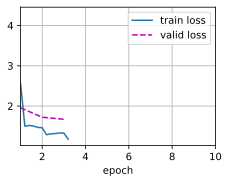

In [18]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CPU


In [11]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define the ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

# Define the training class
class Trainer:
    def __init__(self, model, train_loader, valid_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, num_epochs):
        self.model.to(self.device)
        for epoch in range(num_epochs):
            train_loss = 0.0
            valid_loss = 0.0
            self.model.train()
            for i, (inputs, labels) in enumerate(self.train_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.model.eval()
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(self.valid_loader):
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    valid_loss += loss.item() * inputs.size(0)
                valid_loss /= len(self.valid_loader.dataset)
            print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, train_loss, valid_loss))

# Define the hyperparameters
num_classes = 120
learning_rate = 0.0001
momentum = 0.9
num_epochs = 10

# Define the device to use for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the ResNet model and move it to the device
model = ResNetModel(num_classes, dropout_prob=0.5).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the device to use for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the trainer object and train the model
trainer = Trainer(model, train_loader, valid_loader, criterion, optimizer, device)
trainer.train(num_epochs)

c:\Users\Hecatia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hecatia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Training Loss: 4.5046, Validation Loss: 3.7830
Epoch: 2, Training Loss: 3.9021, Validation Loss: 3.1122
Epoch: 3, Training Loss: 3.6314, Validation Loss: 2.8222
Epoch: 4, Training Loss: 3.5447, Validation Loss: 2.6295
Epoch: 5, Training Loss: 3.4287, Validation Loss: 2.4998
Epoch: 6, Training Loss: 3.3667, Validation Loss: 2.4279
Epoch: 7, Training Loss: 3.3224, Validation Loss: 2.2732
Epoch: 8, Training Loss: 3.2635, Validation Loss: 2.1992
Epoch: 9, Training Loss: 3.2148, Validation Loss: 2.2530
Epoch: 10, Training Loss: 3.2073, Validation Loss: 2.0539


## **6. Run on the Testing Set and Submit teh Results on Kaggle**

Finally, test your trained model on the test set and upload the results to the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

You are required to submit a screenshot of your score.

## **7. Hints to Improve Your Results**
- Try to increase the batch size and the number of epochs.
- Try deeper ResNet networks.
